In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.models import mobilenet_v3_large
from torchvision.models.vision_transformer import vit_b_32
import torch.nn as nn
import os
import torchvision.transforms as T

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_folder = "E://Kuliah//UPI//SEMESTER 8//dataset skripsi//heatmap fix"
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png'))]

In [6]:
from torch import nn
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
        self.attn_weights = None
        
    def forward(self, x):
        attn_output, attn_weights = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=True,
                                             average_attn_weights=False)
        self.attn_weights = attn_weights
        return attn_output, attn_weights

class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x_attn, attn_weights = self.msa_block(self.layer_norm1(x))
        x = x_attn + x
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x, attn_weights
    
class HybridVitMobilenet(nn.Module):
    def __init__(self,
                 img_size=224, # Training resolution from Table 3 in ViT paper
                 in_channels=3, # Number of channels in input image
                 patch_size=16, # Patch size
                 num_transformer_layers=12, # Layers from Table 1 for ViT-Base
                 embedding_dim=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size=3072, # MLP size from Table 1 for ViT-Base
                 num_heads=12, # Heads from Table 1 for ViT-Base
                 attn_dropout=0., # Dropout for attention projection
                 mlp_dropout=0., # Dropout for dense/MLP layers 
                 embedding_dropout=0., # Dropout for patch and position embeddings
                 num_classes=1000,
                 pretrained=False): # Default for ImageNet but can customize this
        super().__init__()
         
        assert img_size % 32 == 0, f"Image size must be divisible by 32, image size: {img_size}"
        
        self.mobilenet = mobilenet_v3_large(pretrained=pretrained).features
        
        self.projection = nn.Conv2d(in_channels=960, 
                                    out_channels=embedding_dim,
                                    kernel_size=1)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.num_patches = (img_size // 32) ** 2  # MobileNet reduces spatial size by 32x
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None, return_attentions=False):
        
        batch_size = pixel_values.shape[0]

        # Extract features using MobileNet
        features = self.mobilenet(pixel_values)  # Output shape: (batch_size, 1280, H', W')
        features = self.projection(features)  # Project to embedding_dim: (batch_size, embedding_dim, H', W')

        # Flatten the feature maps into a sequence of tokens
        features = features.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embedding_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = torch.cat((class_token, features), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        if return_attentions:
            attentions = []
            for layer in self.transformer_encoder:
                x, attn = layer(x)
                attentions.append(attn)
            x = self.norm(x)
            logits = self.head(x[:, 0])
            return logits, attentions
        else:
            for layer in self.transformer_encoder:
                x, _ = layer(x)
            x = self.norm(x)
            logits = self.head(x[:, 0])
        return logits

In [7]:
hybrid = HybridVitMobilenet(num_classes=len(class_names), in_channels=3, num_heads=12, embedding_dim=768, num_transformer_layers=12, mlp_size=3072, pretrained=False)
hybrid = hybrid.to(DEVICE)

C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix//hybrid_mobilenet_vit_best.pt")
hybrid.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_34168\2635014148.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [9]:
hybrid.eval()

HybridVitMobilenet(
  (mobilenet): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1

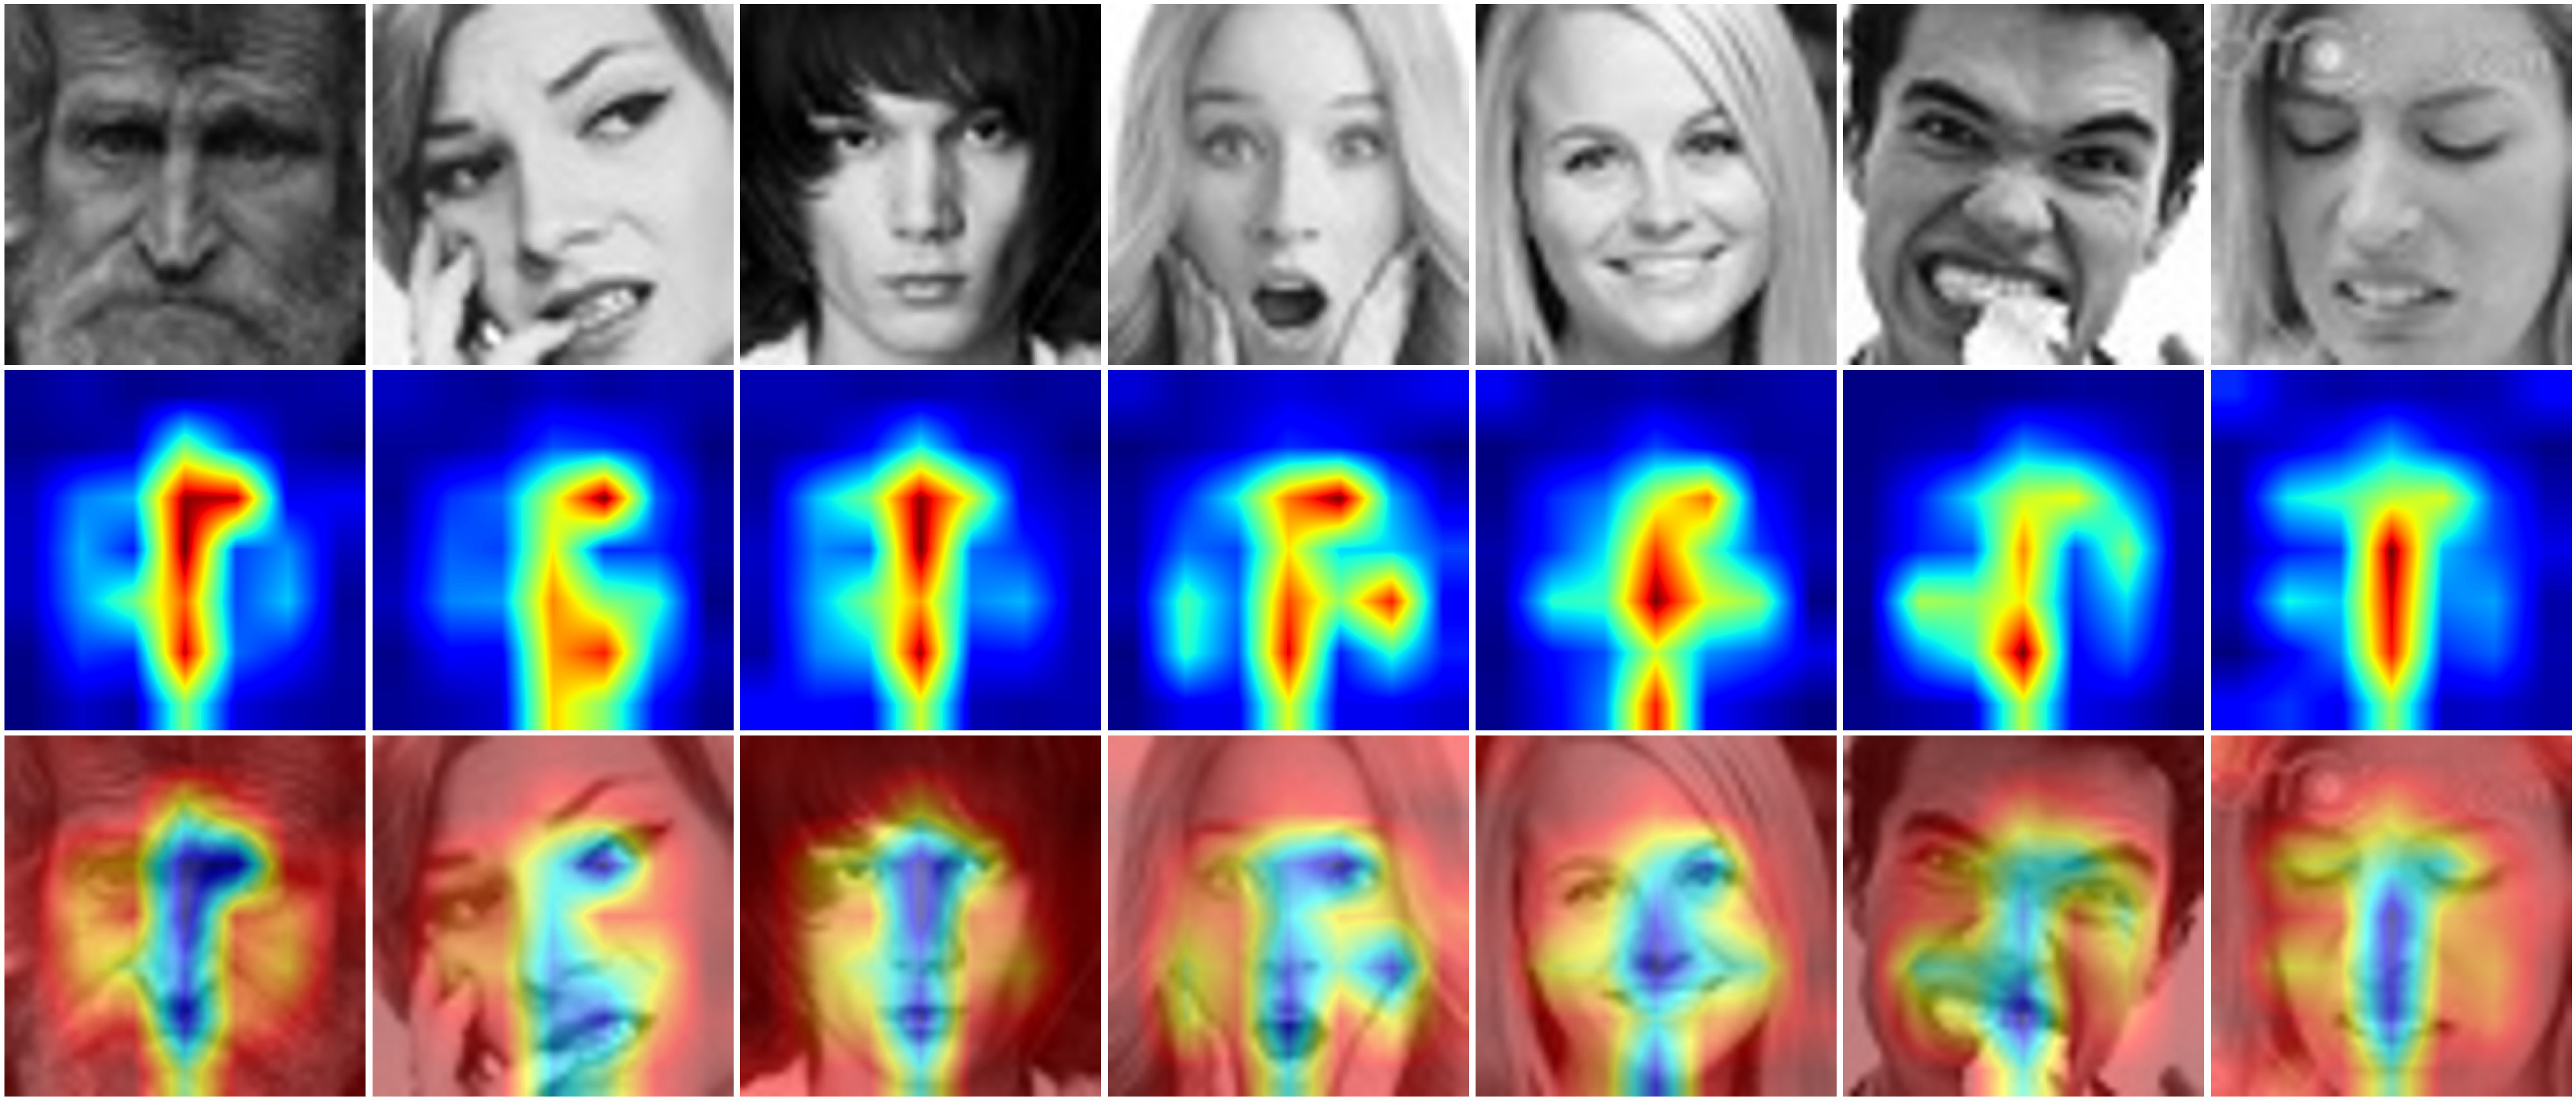

In [ ]:
originals = []
combined_attention_maps = []
combined_overlays = []

for image_path in image_paths:
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        _ = hybrid(input_tensor, return_attentions=True)

    image_np = np.array(img.resize((224, 224))) / 255.0
    originals.append(image_np)

    # List untuk menampung attention per layer
    layer_attns = []

    for layer in hybrid.transformer_encoder:
        attn = layer.msa_block.attn_weights  # [batch, heads, tokens, tokens]
        if attn is None:
            continue
        # Ambil attention dari token [CLS] ke semua patch, rata-rata semua head
        attn_cls = attn[0].mean(0)[0, 1:]  # [tokens - 1] (exclude [CLS])
        layer_attns.append(attn_cls)

    if not layer_attns:
        print(f"Warning: no attention available for {image_path}")
        continue

    # Gabungkan semua layer (mean)
    combined_attn = torch.stack(layer_attns).mean(0)  # [num_patches]

    try:
        # Jadikan peta spasial
        attn_map = combined_attn.reshape(7, 7).cpu().numpy()
    except:
        print(f"Error reshaping attention for {image_path}")
        continue

    # Skala kembali ke ukuran gambar input
    attn_map_resized = cv2.resize(attn_map, (224, 224))
    # Normalisasi
    attn_map_norm = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())

    # Gabung heatmap dengan gambar asli
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_map_norm), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + image_np
    overlay = overlay / np.max(overlay)

    combined_attention_maps.append(attn_map_norm)
    combined_overlays.append(overlay)

# Plot hasil
num_images = len(originals)
fig, axes = plt.subplots(3, num_images, figsize=(8 * num_images, 24))

for i in range(num_images):
    axes[0, i].imshow(originals[i])
    axes[0, i].axis('off')

    axes[1, i].imshow(combined_attention_maps[i], cmap='jet')
    axes[1, i].axis('off')

    axes[2, i].imshow(combined_overlays[i])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
        self.attn_weights = None
        
    def forward(self, x):
        attn_output, attn_weights = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=True,
                                             average_attn_weights=False)
        self.attn_weights = attn_weights
        return attn_output, attn_weights

class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x
    
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x_attn, attn_weights = self.msa_block(self.layer_norm1(x))
        x = x_attn + x
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x, attn_weights
    
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None, return_attentions=False):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        if return_attentions:
            attentions = []
            for layer in self.transformer_encoder:
                x, attn = layer(x)
                attentions.append(attn)
            x = self.norm(x)
            cls_token_final = x[:, 0]
            logits = self.head(cls_token_final)
            return logits, attentions
        else:
            for layer in self.transformer_encoder:
                x, _ = layer(x)
            x = self.norm(x)
            cls_token_final = x[:, 0]
            logits = self.head(cls_token_final)
        return logits

In [12]:
vit = ViT(num_classes=len(class_names), 
                in_channels=3, 
                patch_size=32, 
                num_heads=12, 
                embedding_dim=768, 
                num_transformer_layers=12,
                mlp_size=3072)
vit.to(DEVICE)

ViT(
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (embedding_dropout): Dropout(p=0.0, inplace=False)
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (msa_block): MultiheadSelfAttentionBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp_block): MLPBlock(
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (1): TransformerEncoderBlock(
      (layer_norm

In [13]:
checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen fix//vit_scratch_wAugment_best.pt")
vit.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_34168\2237753608.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [14]:
vit.eval()

ViT(
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (embedding_dropout): Dropout(p=0.0, inplace=False)
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (msa_block): MultiheadSelfAttentionBlock(
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp_block): MLPBlock(
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (1): TransformerEncoderBlock(
      (layer_norm

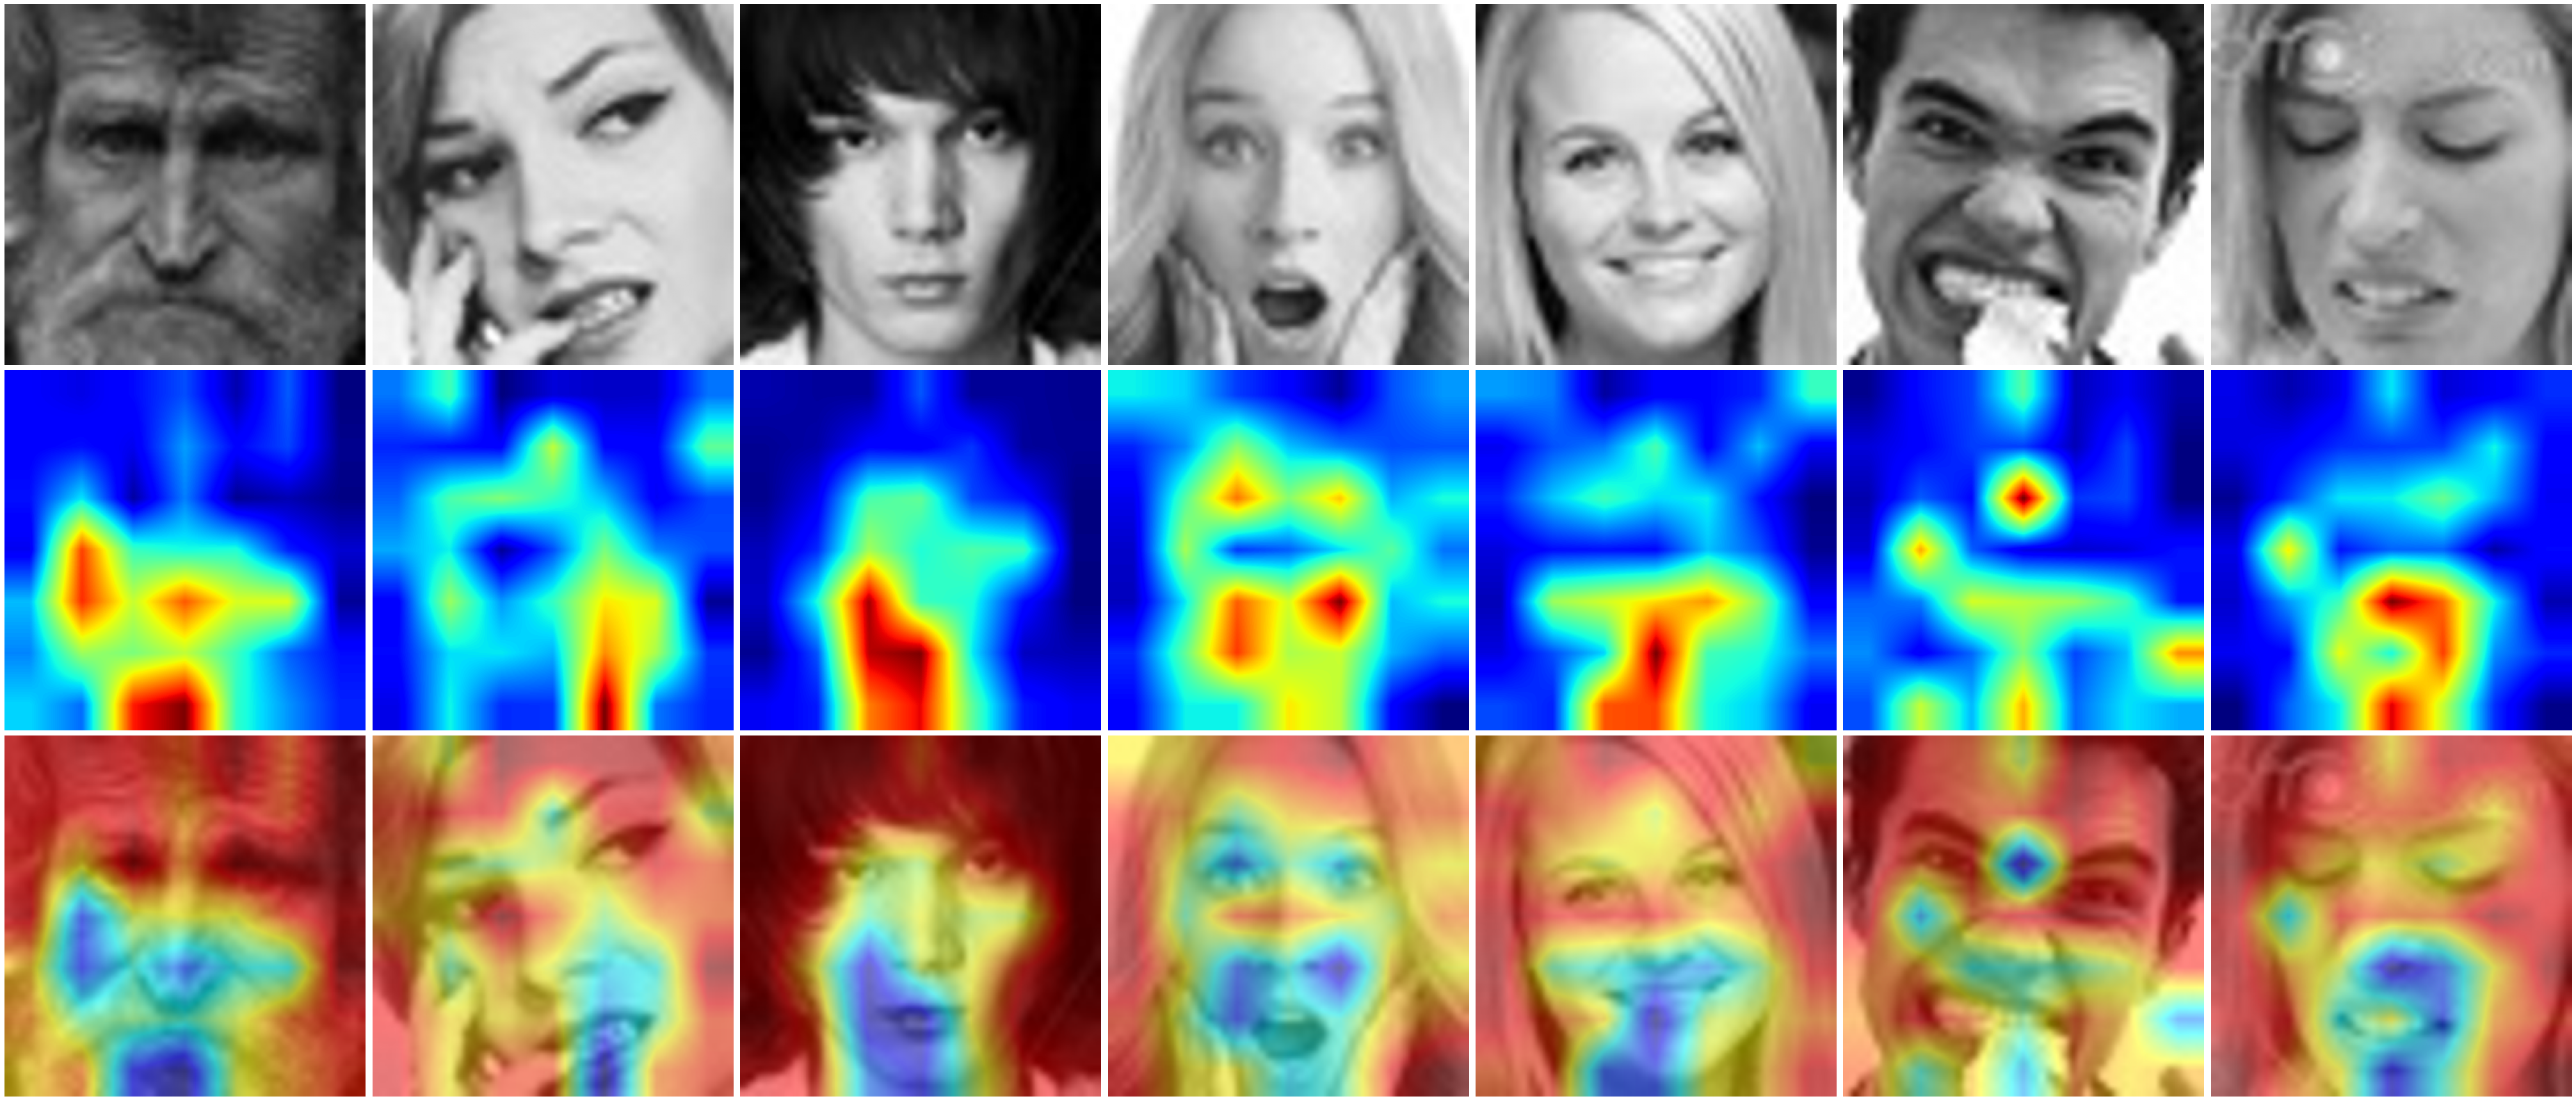

In [23]:
originals = []
combined_attention_maps = []
combined_overlays = []

for image_path in image_paths:
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        _ = vit(input_tensor, return_attentions=True)

    image_np = np.array(img.resize((224, 224))) / 255.0
    originals.append(image_np)

    # List untuk menampung attention per layer
    layer_attns = []

    for layer in vit.transformer_encoder:
        attn = layer.msa_block.attn_weights  # [batch, heads, tokens, tokens]
        if attn is None:
            continue
        # Ambil attention dari token [CLS] ke semua patch, rata-rata semua head
        attn_cls = attn[0].mean(0)[0, 1:]  # [tokens - 1] (exclude [CLS])
        layer_attns.append(attn_cls)

    if not layer_attns:
        print(f"Warning: no attention available for {image_path}")
        continue

    # Gabungkan semua layer (mean)
    combined_attn = torch.stack(layer_attns).mean(0)  # [num_patches]

    try:
        attn_map = combined_attn.reshape(7, 7).cpu().numpy()
    except:
        print(f"Error reshaping attention for {image_path}")
        continue

    attn_map_resized = cv2.resize(attn_map, (224, 224))
    attn_map_norm = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * attn_map_norm), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + image_np
    overlay = overlay / np.max(overlay)

    combined_attention_maps.append(attn_map_norm)
    combined_overlays.append(overlay)

# Plot hasil gabungan
num_images = len(originals)
fig, axes = plt.subplots(3, num_images, figsize=(8 * num_images, 24))

for i in range(num_images):
    axes[0, i].imshow(originals[i])
    axes[0, i].axis('off')

    axes[1, i].imshow(combined_attention_maps[i], cmap='jet')
    axes[1, i].axis('off')

    axes[2, i].imshow(combined_overlays[i])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()